In [11]:
# Importing libraries
import numpy as np
import random
from collections import deque
import tqdm
import time
import logging
import pickle
import os
import shutil
from matplotlib import pyplot as plt
from tqdm.keras import TqdmCallback


# for building DQN model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
# importing environment
from contosocabs_env import ContosoCabs_v0

# setting up logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

debugmode = True
path = './models/'
if os.path.exists(path):
    shutil.rmtree(path)
os.mkdir(path)

#### DQN Agent

Deep Q learning agent in the below cell is responsible for 
- Identify the action to taken given the current state. It does using epsilon-greedy strategy.
- It captures the experience into a in-memory buffer.
- It is responsible for training the model by sampling experiences from memory buffer. 

In [12]:
class DQNAgent:
    
    def __init__(self, state_size, action_size, env, epsilon=1, discount_factor=0.98, learning_rate=0.001,
    epsilon_decay=0.0005, epsilon_min=0.0001, batch_size=10):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size 
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_max = epsilon
        self.epsilon_decay = epsilon_decay 
        self.epsilon_min = epsilon_min
        self.learning_rate = learning_rate      
        self.batch_size = batch_size     

        self.state_encoded = 36 # (m + t + d)
        self.memory = deque(maxlen=2000)
        self.model = self.build_model()
        self.env = env

    def build_model(self):
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_encoded, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.summary
        model.compile(loss='mse',optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def state_encod_arch2(self, state):
        """
        convert the (state-action) into a vector so that it can be fed to the NN. This method converts a given state-action pair into a vector format.
        """
        state_encod = np.array([0 for _ in range(0, self.env.m + self.env.t + self.env.d)])
        state_encod[state[0]] = 1 # start location
        state_encod[self.env.m + state[1]] = 1 # hour of the day
        state_encod[self.env.m + self.env.t + state[2]] = 1 # day of the week
        return state_encod

    def get_action(self, state):
        """
        get action in a state according to an epsilon-greedy approach.
        """
        if np.random.rand() <= self.epsilon:
            # get possible requests/actions given a state
            # choose an action randomly, this will contain the no-ride action
            action = self.env.action_space.sample()
            return self.env.action_space_values[action], action
        else:

            # get q_value for all actions = this should be 21 (20 actions + no ride)
            state_encoded = self.state_encod_arch2(state)
            state_encoded = np.reshape(state_encoded, [1, self.state_encoded])

            # predicting the q value using the model trained so far. 
            q_value = self.model.predict(state_encoded, verbose=0)

            # get the index with max q-value
            max_q_value_index = np.argmax(q_value)

            return self.env.action_space_values[max_q_value_index], max_q_value_index

    # adds the experience to memory
    def append_sample(self, state, action, reward, next_state, hours_of_trip):
        # append the tuple (s, a, r, s', hoursoftrip) to memory (replay buffer) after every action
        self.memory.append((state, action, reward, next_state, hours_of_trip))

    def train_model(self):
        """pick samples randomly from replay memory (with batch_size) and train the network"""
        if len(self.memory) > self.batch_size:
            
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_encoded))
            update_input = np.zeros((self.batch_size, self.state_encoded))
            actions, rewards, trip_hours_per_exp = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, hours_of_trip = mini_batch[i]
                state_encod = self.state_encod_arch2(state)
                next_state_encod = self.state_encod_arch2(next_state)
                update_input[i] = state_encod
                update_output[i] = next_state_encod
                actions.append(action)
                rewards.append(reward)
                trip_hours_per_exp.append(hours_of_trip)
                
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input, verbose=0)   
                
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output, verbose=0)

            #3. Update your 'update_output' and 'update_input' batch. Be careful to use the encoded state-action pair
            for i in range(self.batch_size):
                # find if it is the terminal state
                if (trip_hours_per_exp[i] >= self.env.episode_length):
                    # if it is the terminal state (i.e. if it is the end of the month) then the target q value is just the reward
                    new_q = rewards[i]
                else:
                    # if it is not terminal state then the target value = reward + discount * (max(q(next_state, a)))
                    new_q= rewards[i] + self.discount_factor * (np.amax(target_qval[i]))
                
                # update the target value
                target[i][self.env.action_space_values.index(actions[i])] = new_q

            # 4. Fit your model and track the loss values
            history = self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            return history

    def save_obj(self, obj, name ):
        with open('./models/' + name + '.pkl', 'wb') as f:
            pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [13]:
# run the agent once
env = ContosoCabs_v0({})
state_size = len(env.observation_space.spaces)
action_size = env.action_space.n   
agent = DQNAgent(state_size, action_size, env=env)
current_state = env.state_init
total_reward = 0
env.reset()
while not env.done: 
    action, index = agent.get_action(current_state)
    next_state, reward, done, info = env.step(index)
    agent.append_sample(current_state, action, reward, next_state, info["hours_of_trip"])
    current_state = next_state
    total_reward += reward
logger.info(f"Total Reward: {total_reward}")

Total Reward: 221
Total Reward: 221
Total Reward: 221


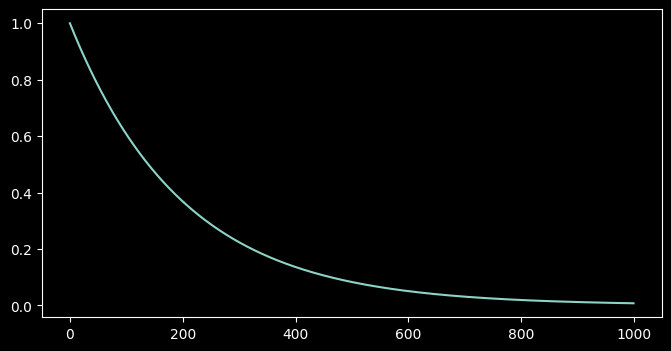

In [22]:
episodes = 1000
epsilon_decay = 0.005
epsilon_min = 0.001
plt.figure(0, figsize=(8,4))
time = np.arange(0,episodes)
epsilon = []
for i in range(0,episodes):
    epsilon.append(epsilon_min + (1.0 - epsilon_min) * np.exp(-epsilon_decay*i))
plt.plot(time, epsilon)
plt.show()

In [16]:
env = ContosoCabs_v0({})
state_size = len(env.observation_space.spaces)
action_size = env.action_space.n # len(env.action_space.spaces), 5*5
start_time = time.time()
rewards_tracked = []
loss_tracked = []

# hyper parameters
episodes = 20
epsilon_decay = 0.005
learning_rate = 0.001
epsilon_min = 0.001
batch_size = 64
threshold = 10
agent = DQNAgent(state_size, action_size, env=env, learning_rate=learning_rate, epsilon_decay=epsilon_decay, epsilon_min=epsilon_min, batch_size=batch_size)
current_state = env.state_init
for episode in tqdm.tqdm(range(episodes)):
    env.reset()
    total_reward = 0
    training_steps = 0
    while not env.done: 
        # index returns from 0-25, action returns a tuple of source and destination
        action, index = agent.get_action(current_state)
        next_state, reward, done, info = env.step(index)
        agent.append_sample(current_state, action, reward, next_state, info["hours_of_trip"])
        if training_steps % 10 == 0:
            history = agent.train_model()
        # Track Loss
        if (history is not None):
            loss = history.history["loss"][0]
            loss_tracked.append(loss)
    
        # next state becomes current state for next step
        current_state = next_state
        # Keep a track of rewards, Q-values, loss
        total_reward += reward
        training_steps +=1

    # Track rewards
    rewards_tracked.append(total_reward)
    # Save the model 
    if episode % threshold == 0:
        logger.debug("Saving data..")
        agent.model.save("./models/contosocabs.h5", overwrite=True)
        agent.save_obj(rewards_tracked, "rewards_tracked")
        agent.save_obj(loss_tracked, "loss_tracked")
    
    logger.debug(f"Episode: {episode} Total Reward: {total_reward}, epsilon: {agent.epsilon}")
    agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(-agent.epsilon_decay * episode)
elapsed_time = time.time() - start_time
print('test')
logger.info(f'Time 1taken: {round(elapsed_time/60,2)} min')

100%|██████████| 20/20 [00:16<00:00,  1.18it/s]
Time 1taken: 0.28 min
Time 1taken: 0.28 min
Time 1taken: 0.28 min


test


### Reporting


In [17]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

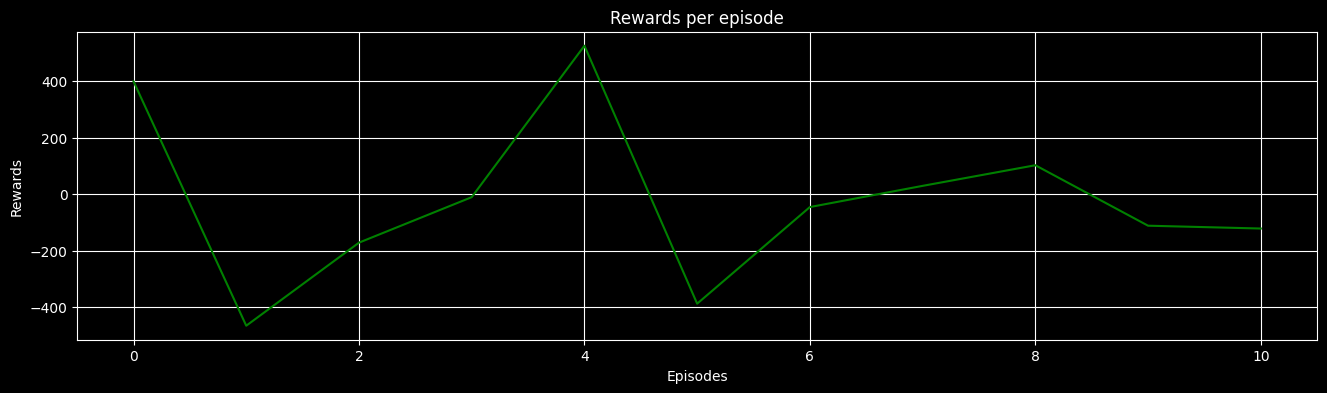

In [20]:
with open('./models/rewards_tracked.pkl', 'rb') as handle:
    rewards_tracked = pickle.load(handle)    
x_axis = np.asarray(range(0, len(rewards_tracked)))
y_axis = np.asarray(rewards_tracked)
plt.figure(0, figsize=(16,4))
plt.title('Rewards per episode')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.plot(x_axis,y_axis,'green')
plt.grid()
plt.show()

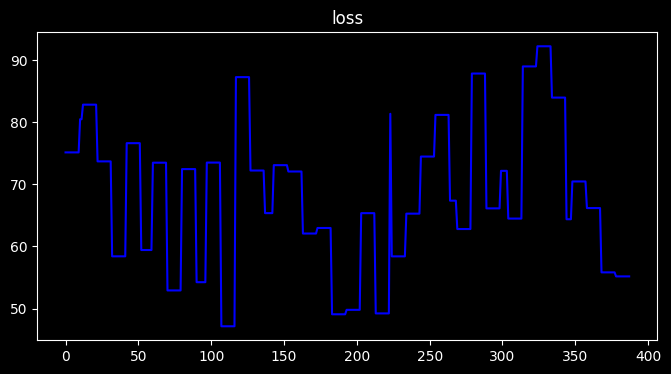

In [21]:
with open('./models/loss_tracked.pkl', 'rb') as handle:
    loss_tracked = pickle.load(handle)    
x_axis = np.asarray(range(0, len(loss_tracked)))
y_axis = np.asarray(loss_tracked)
plt.figure(0, figsize=(8,4))
plt.title('loss')
plt.plot(x_axis,y_axis,'blue')
plt.show()

## Inference

In [24]:
from keras.models import load_model
env = ContosoCabs_v0({})
state_size = len(env.observation_space.spaces)
action_size = env.action_space.n   
agent = DQNAgent(state_size, action_size, env=env)
model = load_model('models/contosocabs.h5')
encoded_state = agent.state_encod_arch2(env.state_init)
model.predict(np.array([encoded_state]))

1/1 [==============================] - 0s 60ms/step


array([[0.        , 0.        , 0.        , 0.2046077 , 0.27776864,
        0.        , 0.        , 0.        , 0.        , 0.61870795,
        0.        , 0.43893215, 0.        , 0.        , 0.35691908,
        0.        , 0.09764144, 0.        , 0.        , 0.03875615,
        0.15912236, 0.590139  , 0.        , 0.        , 0.        ]],
      dtype=float32)